***Проект: вариант 1***

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import pingouin as pg

import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

***Задание 1***

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру. Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

**1 этап - Предобработка данных**

In [9]:
# Посмотрим на данные о времени регистрации игроков

url = 'https://disk.yandex.ru/d/cQhXPVCOwUcdxQ'
reg_data = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url}', sep=';')

In [10]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [11]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [12]:
# Конвертируем время из timestamp в "человекочитаемый" вид 

reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.strftime('%Y-%m-%d')

In [13]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [14]:
reg_data.shape

(1000000, 2)

In [15]:
reg_data.dtypes

reg_ts    object
uid        int64
dtype: object

In [16]:
# Посмотрим за какое время мы имеем данные (первая и последняя дата)

reg_data['reg_ts'].agg(['min', 'max'])

min    1998-11-18
max    2020-09-23
Name: reg_ts, dtype: object

In [17]:
# Посмотрим на количество уникальных пользователей, в этом датасете все uid уникальны.

reg_data.uid.nunique()

1000000

In [18]:
# Посмотрим на данные о времени захода пользователей в игру (авторизации)

url = 'https://disk.yandex.ru/d/FH31O7JETbZOug'
auth_data = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url}', sep=';')

In [19]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [20]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [21]:
# Конвертируем время из timestamp в "человекочитаемый" вид 

auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.strftime('%Y-%m-%d')

In [22]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [23]:
auth_data.dtypes

auth_ts    object
uid         int64
dtype: object

In [24]:
auth_data.shape

(9601013, 2)

In [38]:
# Посмотрим за какое время мы имеем данные (первая и последняя дата)

auth_data['auth_ts'].agg(['min', 'max'])

min    1998-11-18
max    2020-09-23
Name: auth_ts, dtype: object

In [39]:
# Объединим датафреймы

data = reg_data.merge(auth_data, how='inner', on='uid')
data.shape

(9601013, 3)

In [40]:
data['reg_ts'] = pd.to_datetime(data['reg_ts'], format='%Y-%m-%d')
data['auth_ts'] = pd.to_datetime(data['auth_ts'], format='%Y-%m-%d')

In [41]:
data.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [42]:
data.dtypes

reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

In [43]:
# Посчитаем разницу между датой регистрации и датой авторизации (в днях)

data['diff'] = data.auth_ts.dt.to_period('D').astype(int) - data.reg_ts.dt.to_period('D').astype(int)
data = data[['uid', 'reg_ts', 'auth_ts', 'diff']]

In [44]:
data.head()

,uid,reg_ts,auth_ts,diff
0,1,1998-11-18,1998-11-18,0
1,2,1999-07-22,1999-07-22,0
2,2,1999-07-22,1999-07-25,3
3,2,1999-07-22,1999-07-31,9
4,2,1999-07-22,1999-08-05,14


In [45]:
# Сделаем столбец с годом регистрации

data['year_reg'] = data.reg_ts.dt.strftime('%Y')

In [46]:
data.head()

,uid,reg_ts,auth_ts,diff,year_reg
0,1,1998-11-18,1998-11-18,0,1998
1,2,1999-07-22,1999-07-22,0,1999
2,2,1999-07-22,1999-07-25,3,1999
3,2,1999-07-22,1999-07-31,9,1999
4,2,1999-07-22,1999-08-05,14,1999


In [47]:
data.dtypes

uid                  int64
reg_ts      datetime64[ns]
auth_ts     datetime64[ns]
diff                 int64
year_reg            object
dtype: object

In [48]:
# Скорректируем формат - в datetime

data['year_reg'] = pd.to_datetime(data['year_reg'], format='%Y')

In [49]:
# Посмотрим, сколько регистрировалось пользователей по годам

regs_by_year = data.groupby('year_reg').agg({'uid': 'count'}).reset_index().rename(columns={'uid': 'count_users'})
regs_by_year

,year_reg,count_users
0,1998-01-01,1
1,1999-01-01,1929
2,2000-01-01,4
3,2001-01-01,6
4,2002-01-01,34
5,2003-01-01,49
6,2004-01-01,96
7,2005-01-01,1538
8,2006-01-01,9288
9,2007-01-01,6523


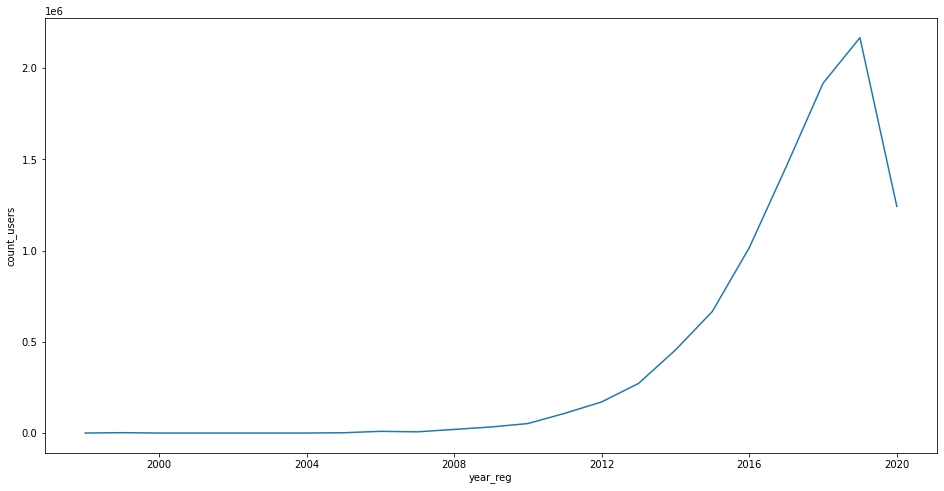

In [51]:
# Посмотрим на графике - количество зарегистрированных пользователей по годам.
# Видим рост количества регистраций по годам. В 2020 год провал, т.к. имеем не полные данные.

ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(data=regs_by_year, x="year_reg", y="count_users")

In [52]:
# Выбираем нужный год

YEAR = 2019
data_year = data.query('year_reg == @YEAR')
data_year

,uid,reg_ts,auth_ts,diff,year_reg
6191436,393071,2019-01-01,2019-01-01,0,2019-01-01
6191437,393073,2019-01-01,2019-01-01,0,2019-01-01
6191438,393074,2019-01-01,2019-01-01,0,2019-01-01
6191439,393075,2019-01-01,2019-01-01,0,2019-01-01
6191440,393076,2019-01-01,2019-01-01,0,2019-01-01
...,...,...,...,...,...
8358762,716359,2019-12-31,2019-12-31,0,2019-01-01
8358763,716360,2019-12-31,2019-12-31,0,2019-01-01
8358764,716361,2019-12-31,2019-12-31,0,2019-01-01
8358765,716361,2019-12-31,2020-01-03,3,2019-01-01


In [53]:
# Считаем количество зарегистрированных пользователей (по дням)

reg_users = data_year.groupby('reg_ts')\
    .agg({'uid': 'nunique'})\
    .reset_index()\
    .rename(columns={'uid': 'count_reg_users'})
reg_users

,reg_ts,count_reg_users
0,2019-01-01,583
1,2019-01-02,583
2,2019-01-03,585
3,2019-01-04,585
4,2019-01-05,586
...,...,...
360,2019-12-27,1053
361,2019-12-28,1054
362,2019-12-29,1057
363,2019-12-30,1058


In [54]:
# Посмотрим на min, max, mean значения регистраций в течение года

reg_users['count_reg_users'].agg(['min', 'max', 'mean']).round()

min      583.0
max     1060.0
mean     798.0
Name: count_reg_users, dtype: float64

In [55]:
data_year

,uid,reg_ts,auth_ts,diff,year_reg
6191436,393071,2019-01-01,2019-01-01,0,2019-01-01
6191437,393073,2019-01-01,2019-01-01,0,2019-01-01
6191438,393074,2019-01-01,2019-01-01,0,2019-01-01
6191439,393075,2019-01-01,2019-01-01,0,2019-01-01
6191440,393076,2019-01-01,2019-01-01,0,2019-01-01
...,...,...,...,...,...
8358762,716359,2019-12-31,2019-12-31,0,2019-01-01
8358763,716360,2019-12-31,2019-12-31,0,2019-01-01
8358764,716361,2019-12-31,2019-12-31,0,2019-01-01
8358765,716361,2019-12-31,2020-01-03,3,2019-01-01


In [56]:
# Считаем количество авторизованных (зашедших в игру) пользователей (по дням)

auth_users = data_year.query('diff != 0')\
    .groupby(['reg_ts', 'diff'])\
    .agg({'uid': 'nunique'})\
    .reset_index()\
    .rename(columns={'uid': 'count_auth_users'})
auth_users

,reg_ts,diff,count_auth_users
0,2019-01-01,1,12
1,2019-01-01,2,22
2,2019-01-01,3,29
3,2019-01-01,4,26
4,2019-01-01,5,37
...,...,...,...
163865,2019-12-31,263,15
163866,2019-12-31,264,18
163867,2019-12-31,265,11
163868,2019-12-31,266,19


In [57]:
# Объединим датафреймы с количеством пользователей по регистрации и авторизации

data_result_by_year = reg_users.merge(auth_users, how='left', on='reg_ts')
data_result_by_year = data_result_by_year[['reg_ts', 'diff', 'count_auth_users', 'count_reg_users']]
data_result_by_year

,reg_ts,diff,count_auth_users,count_reg_users
0,2019-01-01,1,12,583
1,2019-01-01,2,22,583
2,2019-01-01,3,29,583
3,2019-01-01,4,26,583
4,2019-01-01,5,37,583
...,...,...,...,...
163865,2019-12-31,263,15,1060
163866,2019-12-31,264,18,1060
163867,2019-12-31,265,11,1060
163868,2019-12-31,266,19,1060


In [58]:
# Посчитаем Retention Rate (в %) по дням

data_result_by_year['RR'] = (100 * (data_result_by_year['count_auth_users'] / data_result_by_year['count_reg_users']))\
    .round(2)
data_result_by_year

,reg_ts,diff,count_auth_users,count_reg_users,RR
0,2019-01-01,1,12,583,2.06
1,2019-01-01,2,22,583,3.77
2,2019-01-01,3,29,583,4.97
3,2019-01-01,4,26,583,4.46
4,2019-01-01,5,37,583,6.35
...,...,...,...,...,...
163865,2019-12-31,263,15,1060,1.42
163866,2019-12-31,264,18,1060,1.70
163867,2019-12-31,265,11,1060,1.04
163868,2019-12-31,266,19,1060,1.79


In [59]:
# Оставим только первые 30 дней со дня регистрации

data_result_by_year_30 = data_result_by_year.query('diff <= 30')
data_result_by_year_30

,reg_ts,diff,count_auth_users,count_reg_users,RR
0,2019-01-01,1,12,583,2.06
1,2019-01-01,2,22,583,3.77
2,2019-01-01,3,29,583,4.97
3,2019-01-01,4,26,583,4.46
4,2019-01-01,5,37,583,6.35
...,...,...,...,...,...
163628,2019-12-31,26,37,1060,3.49
163629,2019-12-31,27,39,1060,3.68
163630,2019-12-31,28,30,1060,2.83
163631,2019-12-31,29,26,1060,2.45


In [60]:
min_date = "2019-06-01"

In [61]:
max_date = "2019-06-30"

In [73]:
# Выберем нужные каторты для рассмотрения

data_result_by_year_period = data_result_by_year_30.query('@min_date <= reg_ts <= @max_date')
data_result_by_year_period

,reg_ts,diff,count_auth_users,count_reg_users,RR
83944,2019-06-01,1,10,746,1.34
83945,2019-06-01,2,33,746,4.42
83946,2019-06-01,3,37,746,4.96
83947,2019-06-01,4,37,746,4.96
83948,2019-06-01,5,40,746,5.36
...,...,...,...,...,...
97482,2019-06-30,26,30,783,3.83
97483,2019-06-30,27,19,783,2.43
97484,2019-06-30,28,22,783,2.81
97485,2019-06-30,29,23,783,2.94


In [74]:
data_result_by_year_period.reg_ts = pd.to_datetime(data_result_by_year_period.reg_ts).astype('string')

In [75]:
# Построим pivot-таблицу

data_result_by_year_period_pivot = data_result_by_year_period.pivot_table(index='reg_ts', columns='diff', values='RR')\
    .fillna(0)
data_result_by_year_period_pivot

diff,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2019-06-01,1.34,4.42,4.96,4.96,5.36,8.45,5.50,4.16,4.96,4.29,...,3.75,4.96,3.62,3.08,3.62,3.49,3.08,3.08,3.35,1.47
2019-06-02,2.14,4.14,3.07,4.95,4.81,6.42,5.48,4.68,4.01,4.01,...,3.34,3.48,3.48,1.74,4.14,3.34,2.01,3.48,2.94,3.07
2019-06-03,2.00,3.20,4.14,5.21,5.74,6.81,4.01,4.67,5.47,5.61,...,3.60,4.14,3.74,4.67,3.20,4.14,3.60,3.74,3.74,3.34
2019-06-04,1.46,3.20,4.53,4.79,5.46,5.59,6.13,4.39,5.33,4.53,...,3.86,2.80,3.46,2.53,3.46,2.80,2.66,1.46,2.40,2.80
2019-06-05,1.46,4.39,4.66,4.79,6.79,6.52,6.13,4.93,5.59,4.79,...,3.73,3.86,3.06,4.39,3.73,3.33,3.60,2.13,3.73,2.53
2019-06-06,2.26,4.38,5.58,5.71,5.98,7.70,7.44,5.44,6.37,5.05,...,4.38,3.19,3.98,5.71,3.98,3.05,4.12,2.66,2.66,4.25
2019-06-07,2.12,4.11,5.84,4.91,5.97,6.76,5.17,5.31,5.57,4.24,...,3.98,3.58,1.99,4.11,3.58,2.65,3.32,3.18,2.79,2.79
2019-06-08,1.46,3.44,4.64,4.77,6.23,6.89,5.03,3.44,5.43,4.50,...,3.71,2.91,4.37,2.52,3.44,3.58,2.25,3.05,2.12,2.78
2019-06-09,1.72,3.30,5.02,3.83,7.27,7.40,6.74,4.10,5.42,4.89,...,3.96,3.17,4.23,3.17,4.36,2.25,2.77,3.57,3.30,3.96


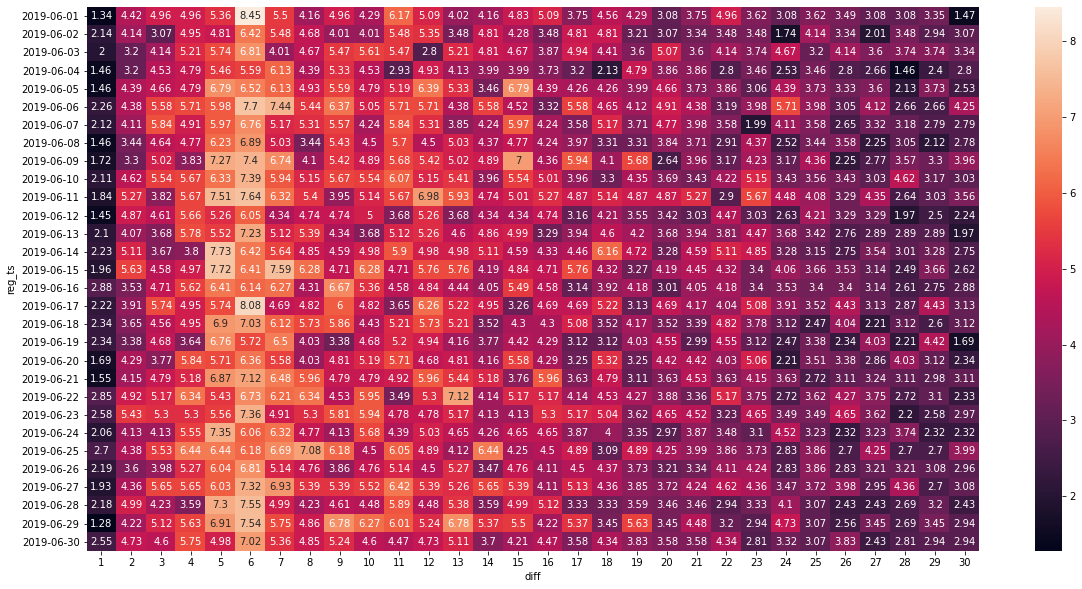

In [76]:
# Построим тепловую карту

plt.subplots(figsize=(20, 10))
sns.heatmap(data_result_by_year_period_pivot, annot=True, fmt="g")
plt.show()

**2 этап - Создание функции, проверка ее работы и формулирование выводов**

In [77]:
def RR_by_days(path_to_file_reg, path_to_file_auth, min_date, max_date):
    """
    Считает метрику Retention Rate пользователей по дням со дня регистрации (в %) и строит тепловую карту.
            Параметры:
                    path_to_file_reg (csv): путь к файлу о времени регистрации пользователей. 
                    Датафрейм имеет структуру:
                        reg_ts (timestamp) - время регистрации пользователя
                        uid (int) - ID пользователя
                        
                    path_to_file_auth (csv): путь к файлу о времени захода пользователей в игру (авторизации). 
                    Датафрейм имеет структуру:
                        auth_ts (timestamp) - время авторизации пользователя
                        uid (int) - ID пользователя
                    
                    min_date (str):  min дата диапазона в формате "Y-m-d" 
                    max_date (str): max дата диапазона в формате "Y-m-d"
                    
            Возвращаемое значение:
                    heatmap - тепловая карта с метрикой Retention Rate пользователей (в %) по дням со дня регистрации
    """
    reg_data = pd.read_csv(filepath_or_buffer=path_to_file_reg, sep=';') 
    # Считываем файл с временем регистрации пользователей
    auth_data = pd.read_csv(filepath_or_buffer=path_to_file_auth, sep=';')
    # Считываем файл с временем авторизации пользователей

    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')  # Конвертируем  даты из timestamp в datetime 
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
    
    max_date = datetime.strptime(max_date, '%Y-%m-%d')
    max_date_auth = max_date + timedelta(days=30) 
    # Добавляем к max_date 30 дней (т.к. когортный анализ делаем на 30 дней со дня регистрации)
    
    reg_data = reg_data.query('@min_date <= reg_ts <= @max_date')  # Выбираем нужный период
    auth_data = auth_data.query('@min_date <= auth_ts <= @max_date_auth')

    
    data = reg_data.merge(auth_data, how='inner', on='uid')
    
    data['reg_ts'] = data.reg_ts.dt.strftime('%Y-%m-%d')  # Скорректируем формат даты 
    data['auth_ts'] = data.auth_ts.dt.strftime('%Y-%m-%d')
    data['reg_ts'] = pd.to_datetime(data['reg_ts'])
    data['auth_ts'] = pd.to_datetime(data['auth_ts'])
    
    data['diff'] = data.auth_ts.dt.to_period('D').astype(int) - data.reg_ts.dt.to_period('D').astype(int) 
    # Посчитаем разницу между датой регистрации и датой авторизации (в днях)
 
    reg_users = data.groupby('reg_ts')\
        .agg({'uid': 'nunique'})\
        .reset_index()\
        .rename(columns={'uid': 'count_reg_users'}) 
    # Считаем кол-во уникальных зарегистрированных пользователей (по дням)
    
    auth_users = data.query('diff != 0')\
        .groupby(['reg_ts', 'diff'])\
        .agg({'uid': 'nunique'})\
        .reset_index()\
        .rename(columns={'uid': 'count_auth_users'})
    # Считаем кол-во уникальных авторизованных (зашедших в игру) пользователей (по дням)
    
    data_result = reg_users.merge(auth_users, how='left', on='reg_ts')
    # Объединяем датафреймы
    
    data_result['RR'] = (100 * (data_result['count_auth_users'] / data_result['count_reg_users'])).round(2)
    # Посчитаем Retention Rate (в %) по дням
    
    data_result['reg_ts'] = data_result.reg_ts.astype(str)
    
    data_result_month = data_result.query('diff <= 30')
    # Смотрим только первые 30 дней со дня регистрации
    
    data_result_pivot = data_result_month.pivot_table(index='reg_ts', columns='diff', values='RR').fillna(0) 
    # Построим pivot-таблицу
    
    plt.subplots(figsize=(20, 10))
    sns.heatmap(data_result_pivot, annot=True, fmt="g").set(xlabel="Day", ylabel="Reg_date")
    plt.show()
    # Построим тепловую карту

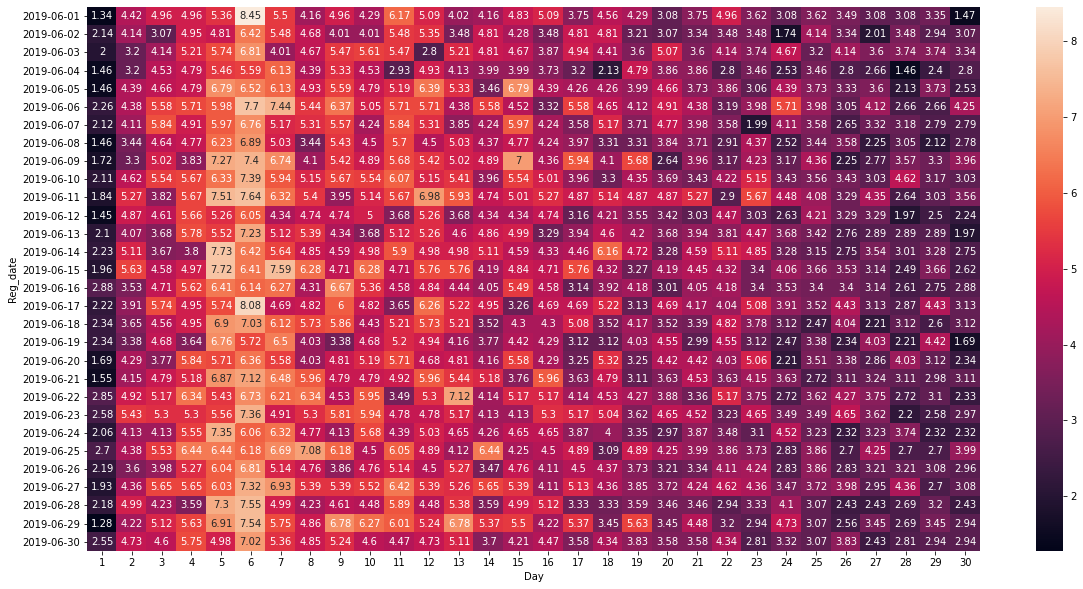

In [78]:
path_to_file_reg = '~/shared/problem1-reg_data.csv'
path_to_file_auth = '~/shared/problem1-auth_data.csv'
min_date = "2019-06-01"
max_date = "2019-07-01"

RR_by_days(path_to_file_reg, path_to_file_auth, min_date, max_date)

**Для общения с менеджером:**

1. Подготовлена функция для расчета метрики Retention Rate (RR) пользователей по дням со дня регистрации (в %) и для визуализации построена тепловая карта.

2. Функция позволяет выбирать нужный временной интервал (min_date; max_date) для даты регистрации. Рекомендуется отображать на тепловой карте не более 1 месяца.

3. На тепловой карте отображается краткосрочный RR на протяжении 30 дней со дня регистрации. При необходимости, можно рассмотреть и долгосрочный RR на протяжении года.

4. Работа функции проверена на временном интервале с 01.06.2019 по 30.06.2019. Мы наблюдаем низкий Retention первого дня (D1) < 2% авторизаций пользователей. Возможно это связано с процессом регистрации, авторизации или оплаты пользователями. Потом наблюдаем увеличение RR на протяжении первых 10-14 дней (наше среднее время удержания в игре) со дня регистрации до 8% и плавный спад к концу месяца. Рекомендуется провести анализ причин низкого RR в первые дни после регистрации.

***Задание 2***

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [79]:
# Посмотрим на результаты проведенного A/B теста

url = 'https://disk.yandex.ru/d/pwAXKiWbckQoDA'
df = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url}', sep=';')

In [80]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [81]:
df.shape

(404770, 3)

In [82]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [85]:
df.revenue.agg(['min', 'max'])

min        0
max    37433
Name: revenue, dtype: int64

In [86]:
# Посмотрим, какое у нас количество пользователей в группах a (контрольная) и b (тестовая)

df.groupby('testgroup').agg({'user_id': 'count'}).reset_index()

,testgroup,user_id
0,a,202103
1,b,202667


In [87]:
# Посмотрим, сколько у нас платящих пользователей по группам

df.query('revenue != 0').groupby('testgroup').agg({'user_id': 'count'}).reset_index()

,testgroup,user_id
0,a,1928
1,b,1805


In [88]:
# Посмотрим на среднее и медианное значение revenue платящих пользователей по группам
# Получаем, что сами по себе средние значения не сильно отличаются в отличии от медианных

df.query('revenue != 0').groupby(['testgroup'])['revenue'].agg(['mean', 'median']).round().reset_index()

,testgroup,mean,median
0,a,2664.0,311
1,b,3004.0,3022


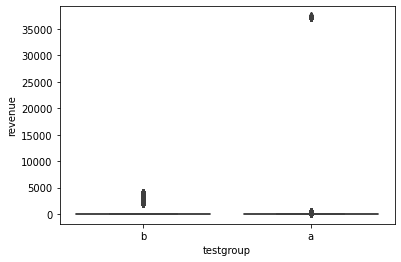

In [89]:
# Видим особо дорогие покупки в контрольной группе.

sns.boxplot(x='testgroup', y='revenue', data=df)

In [90]:
# Посмотрим на распределение revenue для платящих пользователей

df_rev = df.query('revenue != 0')
df_rev.head()

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a


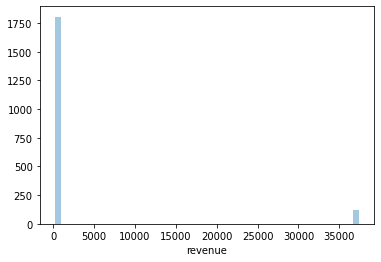

In [91]:
# Посмотрим на распределение revenue платящих пользователей контрольной группы (a)
# Получаем отличное от нормального распределение

sns.distplot(df_rev[df_rev.testgroup == 'a'].revenue, kde=False)

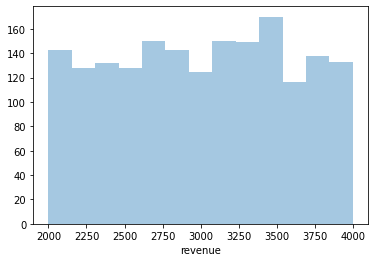

In [92]:
# Посмотрим на распределение revenue платящих пользователей тестовой группы (b)
# Получаем также отличное от нормального распределение

sns.distplot(df_rev[df_rev.testgroup == 'b'].revenue, kde=False)

In [93]:
# Проверим на нормальность распределения через pingouin. Порог нормальности берем по умолчанию (alpfa = 0.05)
# Видим то, что уже получали ранее, распределения revenue платящих пользователей не являются нормальными в группах

pg.normality(data=df_rev, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


In [94]:
# Также при желании можно посмотреть на описательную статистику revenue по группам
# Видим, что в контрольной группе значения revenue колеблются в значительно большем диапазоне что и видели на графике

df_rev.query("testgroup == 'a'")['revenue'].describe().round()

count     1928.0
mean      2664.0
std       9049.0
min        200.0
25%        257.0
50%        311.0
75%        361.0
max      37433.0
Name: revenue, dtype: float64

In [95]:
df_rev.query("testgroup == 'b'")['revenue'].describe().round()

count    1805.0
mean     3004.0
std       573.0
min      2000.0
25%      2513.0
50%      3022.0
75%      3478.0
max      4000.0
Name: revenue, dtype: float64

**Посчитаем некоторые метрики - в частности:**
    
**ARPU** - доход на пользователя

**ARPPU** - доход на платящего пользователя

**CR** - конверсия в покупку

In [96]:
# Посчитаем сумму дохода по группам

sum_by_group = df.groupby('testgroup').agg({'revenue': 'sum'}).reset_index()
sum_by_group

,testgroup,revenue
0,a,5136189
1,b,5421603


In [97]:
# Посчитаем количество пользователей по группам

count_users_by_group = df.groupby('testgroup').agg({'user_id': 'count'}).reset_index()
count_users_by_group

,testgroup,user_id
0,a,202103
1,b,202667


In [98]:
# Посчитаем метрику ARPU (доход с одного пользователя) по группам 

ARPU = (sum_by_group['revenue'] / count_users_by_group['user_id']).round(2)
ARPU

0    25.41
1    26.75
dtype: float64

In [99]:
# Посчитаем сумму дохода с платящих пользователей по группам

sum_p_by_group = df_rev.groupby('testgroup').agg({'revenue': 'sum'}).reset_index()
sum_p_by_group

,testgroup,revenue
0,a,5136189
1,b,5421603


In [100]:
# Посчитаем количество платящих пользователей по группам

count_p_users_by_group = df_rev.groupby('testgroup').agg({'user_id': 'count'}).reset_index()
count_p_users_by_group

,testgroup,user_id
0,a,1928
1,b,1805


In [101]:
# Посчитаем метрику ARPPU (доход с одного платящего пользователя) по группам 

ARPPU = (sum_p_by_group['revenue'] / count_p_users_by_group['user_id']).round(2)
ARPPU

0    2664.00
1    3003.66
dtype: float64

In [102]:
# Посчитаем конверсию в покупку (CR) в тестовой группе

CR = ((count_p_users_by_group['user_id'] / count_users_by_group['user_id']) * 100).round(2)
CR

0    0.95
1    0.89
Name: user_id, dtype: float64

In [103]:
# Доход на одного пользователя (ARPU) в тестовой группе (b=1) выше

ARPU

0    25.41
1    26.75
dtype: float64

In [104]:
# Доход на одного платящего пользователя (ARPPU) в тестовой группе (b=1) выше

ARPPU

0    2664.00
1    3003.66
dtype: float64

In [105]:
# Конверсия в покупку (CR) в контрольной группе (a=0) выше

CR

0    0.95
1    0.89
Name: user_id, dtype: float64

**Теперь перейдем к тестированию.** 

Первое - необходимо определить, какой тест наиболее применим в нашем конкретном случае.
Нам необходимо выбрать один тест, на результаты которого мы и будем ориентироваться.

Мы могли бы применить t-test. Но мы имеем распределения, отличные от нормального, и в тестовой и в контрольной группе. А также у нас сильно отличаются дисперсии в этих группах, что не очень хорошо для применения t-test.

U-тест Манна-Уитни - непараметрический аналог t-test, который более применим, когда распределение не является нормальным. Но U-тест Манна-Уитни более сложен в интерпретации результатов, т.к. показывает различия в средних рангов между группами.

Для решения данной задачи решила применить метод бутстрап, с помощью которого проверяю, являются ли различия в метриках стат значимыми. Проводить эксперимент большое количество раз - это процесс затруднительный и ресурсоемкий, поэтому используем бутстрапированные выборки (считаем их результатом повторения нашего эксперимента) и смотрим на получившееся распределение величины.

Нас интересуют следующие метрики: CR (конверсия в покупку), ARPU(средний доход на одного пользователя), ARPPU(средний доход на одного платящего пользователя).

Гипотеза H0: стат значимых различий в значениях анализируемой метрики (CR / ARPU / ARPPU) в контрольной (a) и тестовой (b) группах нет.

Гипотеза H1 (альтернативная гипотеза): стат значимые различия есть.

In [106]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap( 
    data,  # датафрейм с данными по группам 
    boot_it,  # количество бутстрэп-подвыборок 
    bootstrap_conf_level,  # уровень значимости
    metrica=''  # анализируемая метрика, default metrica = CR
):
    boot_data = []
    boot_len = max([len(data.query("testgroup == 'a'")), len(data.query("testgroup == 'b'"))])
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples = data.sample(boot_len, replace=True)
        if metrica == 'CR' or metrica == '':
            CR_1 = samples.query("testgroup == 'a'").agg({'user_id': 'count'}).user_id\
                / samples.query("testgroup == 'a' and revenue != 0").agg({'user_id': 'count'}).user_id
            CR_2 = samples.query("testgroup == 'b'").agg({'user_id': 'count'}).user_id\
                / samples.query("testgroup == 'b' and revenue != 0").agg({'user_id': 'count'}).user_id
            boot_data.append(CR_1 - CR_2)  # CR
        elif metrica == 'ARPU':
            ARPU_1 = samples.query("testgroup == 'a'").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'a'").agg({'user_id': 'count'}).user_id
            ARPU_2 = samples.query("testgroup == 'b'").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'b'").agg({'user_id': 'count'}).user_id
            boot_data.append(ARPU_1 - ARPU_2)  # ARPU
        elif metrica == 'ARPPU':
            ARPPU_1 = samples.query("testgroup == 'a' and revenue != 0").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'a' and revenue != 0").agg({'user_id': 'count'}).user_id
            ARPPU_2 = samples.query("testgroup == 'b' and revenue != 0").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'b' and revenue != 0").agg({'user_id': 'count'}).user_id
            boot_data.append(ARPPU_1 - ARPPU_2)  # ARPPU
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2

    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

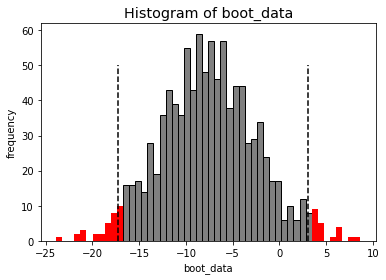

{'boot_data': [-8.04883829051677,
  -12.377899735176996,
  -4.738196860016927,
  -2.5460355419947973,
  -4.952192573200975,
  -8.796110057626052,
  -1.8137051544556186,
  -7.313056144212808,
  -10.625759442867974,
  -11.984451095634057,
  -11.008635415542841,
  -4.035358462481966,
  -7.51703306581355,
  -20.975897898238983,
  -4.2255627697714,
  -6.239701238111309,
  -9.987117673992671,
  -2.903133483375484,
  -9.288028413028414,
  2.017403314917132,
  -9.963868012710392,
  -8.91350549828013,
  -8.586561245511334,
  -7.632472285949461,
  -4.929601971439524,
  -3.9641541843166266,
  4.760834760571527,
  -7.625985536643441,
  -12.131966841996402,
  -10.967962592075907,
  -1.0841367592910984,
  -10.673553621148713,
  -8.092891710061565,
  -13.16234929718317,
  -9.729778243147223,
  -8.416382222612214,
  -17.263824202449868,
  -11.091588679591254,
  -1.184679352680007,
  -5.298184249897986,
  0.7369126049041768,
  -9.165588395931636,
  -7.456864956924676,
  -2.115688717946881,
  -13.590423

In [107]:
# Посмотрим на результат для каждой анализируемой метрики (metrica): CR, ARPU, ARPPU.

get_bootstrap(
    data=df, 
    boot_it=1000,  # количество бутстрэп-подвыборок
    bootstrap_conf_level=0.95,  # уровень значимости
    metrica='CR'
)

boot_it = 1000;

p_value:

CR 0.15

ARPU 0.68

ARPPU 0.25

boot_it = 500;

p_value:

CR 0.13

ARPU 0.66

ARPPU 0.2

In [108]:
# Общее количество пользователй в контрольной группе (a), совершивших покупку.

df_rev.query("testgroup == 'a'").agg({'user_id': 'nunique'})

user_id    1928
dtype: int64

In [109]:
# Количество пользователей в контрольной группе (a), которые совершили высокодоходные покупки.

df_rev.query("testgroup == 'a' and revenue > 5000").agg({'user_id': 'nunique'})

user_id    123
dtype: int64

In [110]:
# Количество пользователей в контрольной группе (a), которые совершили низкодоходные покупки.

df_rev.query("testgroup == 'a' and revenue < 500").agg({'user_id': 'nunique'})

user_id    1805
dtype: int64

**Для общения с менеджером:**

1. Получили, что для каждой анализируемой метрики (CR, ARPU и ARPPU) стат значимых раличий в контрольной и тестовой группах нет. Поэтому дать однозначный ответ, какое акционное предложение является лучшим с точки зрения финансовых показателей, мы не можем. Т.е. конверсии в покупку (CR), средний доход на одного пользователя (ARPU) и средний доход на одного платящего пользователя (ARPPU) в группах стат значимо не различаются.

2. Также мы посмотрели на распределение дохода (revenue) в группах и получили следующие результаты. В контрольной группе (a) мы имеем большую часть покупателей с низкодоходными покупками (revenue < 500) и ряд покупателей с высокодоходными покупкам (revenue > 5000), которые следует отдельно изучить. В тестовой группе (b) показатель дохода (revenue) распределен более равномерно и варьеруется от 2000 до 4000.

**Задание 3**

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Для общения с менеджером:**

1) Изначально посмотрим на метрики привлечения. Какое количество постоянно играющих пользователей (игроков) участвовало в тематическом событии (конверсия в участие в тематическом событии, в %)?

1.1 За всё время тематического события (чтобы увидеть вовлеченность игроков в событие).
  
1.2 По дням проведения тематического события. Например, первый день покажет, как эффективны были маркетинг и презентация собятия. Второй и последующие дни покажет, как событие удерживает игроков (на сколько интересны предложенные награды, соответствуют ли награды приложенным усилиям игроков).

2) Далее посмотрим на средний достигаемый уровень игроков в событии (по дням). Можем сравнить с другими ежемесячными событиями, сделав когортный анализ, посчитав достигаемый уровень игроков по дням и построив heatmap. Таким образом, мы можем оценить скорость получения наград игроками (на сколько сложно проходить уровни) и итоговый результат события.

3) Рассчитав DAU (ежедневные активные пользователи) в течение события и MAU (ежемесячные активные пользователи), можем увидеть, как увеличился приток активных пользователей (игроков).

4) Также можно рассчитать количество сессий в день и среднюю длину сессии на одного пользователя (по событиям). Рассмотреть длину игровой сессии бывает полезно, чтобы понаблюдать, какой процент игровых сессий длится менее Х минут, и какое количество сессий длится более Х минут. Т.е. отслеживать, какой процент пользователей играет долгие периоды времени, в сравнении с теми, кто не надолго заходит в игру.

5) Далее рассмотрим метрики монетизации. Прежде всего можем посмотреть процент платящих игроков от общего числа игроков. Увеличилась ли конверсия в покупку или осталась на прежнем уровне (если игроки не успевают пройти нужные уровни, покупают ли они желаемые награды). Какая самая популярная покупка во время проведения тематического события (в случае если можно приобрести награду).

6) Также можно рассчитать классические метрики ARPU (средний доход на одного пользователя) и ARPPU (средний доход на одного платящего пользователя) и посмотреть, есть ли рост в этих метриках.

7) В случае усложнения механики событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад, предлагаю также рассмотреть:

7.1 Процент (%) игроков, у которых происходит откат уровня.

7.2. Самые частые уровни, с которых откатываются игроки.

7.3. Находясь на каком уровне, игроки делают больше всего покупок.

Предложенные метрики можно рассмотреть для обоих вариантов механики игры, оценив результаты тематических событий между собой.